# Parallel LSTM

## I. Introduction

### 1. RNN

### 2. LSTM

## II. Implementation

#### Libraries and Functions

In [1]:
# Libraries
import math
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
np.random.seed(42)
hidden_size = 50

In [2]:
# Temporarily replace np.random.randn() -> Need to re-implement
def randn(x, y):
  return np.array([[0.5 if (u+i)%2==0 else -0.5 for u in range(y)] for i in range(x)])

In [3]:
# Function: Create a list of sequences as input dataset
def generate_dataset(num_sequences = 100):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 10)
        sample = ['A'] * num_tokens + ['B'] * num_tokens + ['C'] * num_tokens + ['D'] * num_tokens + ['EOS']
        samples.append(sample)
    return samples

# Function: List of sequences -> word_to_idx, idx_to_word, num_sentences, vocab_size
def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist] # Flatten a nested list
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = {}
    for word in flatten(sequences):
        word_count[word] = 0
    for word in flatten(sequences):
        word_count[word] = word_count[word] + 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    word_to_idx = {}
    idx_to_word = {}

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size

# Function: Create and split dataset into Train/Val/Test set
def create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1):
    # Train/Val/Test ratio
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    # Split sequences into Train/Val/Test
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = [(inputs_train[i], targets_train[i]) for i in range(len(inputs_train))]
    validation_set = [(inputs_val[i], targets_val[i]) for i in range(len(inputs_val))]
    test_set = [(inputs_test[i], targets_test[i]) for i in range(len(inputs_test))]    

    return training_set, validation_set, test_set

In [4]:
# Function: One-hot Encoding a word -> 1-D numpy array (len = vocab_size)
def one_hot_encode(word_idx, vocab_size):
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    # Set the appropriate element to one
    one_hot[word_idx] = 1.0
    return one_hot

# Function: One-hot Encoding a sequence -> 3-D numpy array (shape = num words, vocab size, 1)
def one_hot_encode_sequence(sequence, vocab_size):
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

In [5]:
# Activation Function: Sigmoid
def sigmoid(x, derivative=False):
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    # Return the derivative of the function evaluated at x
    if derivative:
        return f * (1 - f)
    # Return the forward pass of the function at x
    else:
        return f

# Activation Function: Tanh
def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    # Return the derivative of the function evaluated at x
    if derivative:
        return 1-f**2
    # Return the forward pass of the function at x
    else:
        return f

# Activation Function: Softmax
def softmax(x, derivative=False):
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

# Function: Clips gradients to have a maximum norm of `max_norm` -> prevent the exploding gradients
def clip_gradient_norm(grads, max_norm=0.25):
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm = total_norm + grad_norm
    total_norm = np.sqrt(total_norm)
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    return grads

In [6]:
# Function: Initializes weight parameters orthogonally
# Paper for explanation of the initialization: https://arxiv.org/abs/1312.6120
def init_orthogonal(param):
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    rows, cols = param.shape
    new_param = randn(rows, cols) #np.random.randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param

# Function: Initializes LSTM network
def init_lstm(hidden_size, vocab_size, z_size):
    # Weight matrix (forget gate)
    W_f = randn(hidden_size, z_size) #np.random.randn(hidden_size, z_size)
    # Bias for forget gate
    b_f = np.zeros((hidden_size, 1))
    # Weight matrix (input gate)
    W_i = randn(hidden_size, z_size) #np.random.randn(hidden_size, z_size)
    # Bias for input gate
    b_i = np.zeros((hidden_size, 1))
    # Weight matrix (candidate)
    W_g = randn(hidden_size, z_size) #np.random.randn(hidden_size, z_size)
    # Bias for candidate
    b_g = np.zeros((hidden_size, 1))
    # Weight matrix of the output gate
    W_o = randn(hidden_size, z_size) #np.random.randn(hidden_size, z_size)
    b_o = np.zeros((hidden_size, 1))
    # Weight matrix relating the hidden-state to the output
    W_v = randn(vocab_size, hidden_size) #np.random.randn(vocab_size, hidden_size)
    b_v = np.zeros((vocab_size, 1))
    # Initialize weights according to https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v

In [7]:
# Function: Forward Pass
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x -- your input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    p (params) -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # First we unpack our parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Save a list of computations for each of the components in the LSTM
    z_s, f_s, i_s, g_s, o_s, v_s = [0] * len(inputs), [0] * len(inputs), [0] * len(inputs), [0] * len(inputs), [0] * len(inputs), [0] * len(inputs)
    output_s = [0] * len(inputs)
    h_s, C_s = [0] * (len(inputs)+1), [0] * (len(inputs)+1)
    
    # Append the initial cell and hidden state to their respective lists
    h_s[0] = h_prev
    C_s[0] = C_prev
    
    for idx, x in enumerate(inputs):
        
        # Concatenate input and hidden state
        z = np.row_stack((h_prev, x))
        z_s[idx] = z
        
        # Calculate forget gate
        f = sigmoid(np.dot(W_f, z) + b_f)
        f_s[idx] = f
        
        # Calculate input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s[idx] = i
        
        # Calculate candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s[idx] = g
        
        # Calculate memory state
        C_prev = f * C_prev + i * g
        C_s[idx+1] = C_prev
        
        # Calculate output gate
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s[idx] = o
        
        # Calculate hidden state
        h_prev = o * tanh(C_prev)
        h_s[idx+1] = h_prev

        # Calculate logits
        v = np.dot(W_v, h_prev) + b_v
        v_s[idx] = v
        
        # Calculate softmax
        output = softmax(v)
        output_s[idx] = output

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s

# Function: Backward Pass
def backward(z, f, i, g, C, o, h, v, outputs, targets, p):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    p (params) -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Track loss
    loss = 0
    
    for t in reversed(range(len(outputs))):
        
        # Compute the cross entropy
        loss = loss + (-np.mean(np.log(outputs[t]) * targets[t]))
        # Get the previous hidden cell state
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] = dv[np.argmax(targets[t])] - 1

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d = W_v_d + np.dot(dv, h[t].T)
        b_v_d = b_v_d + dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)
        dh = dh + dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d = W_o_d + np.dot(do, z[t].T)
        b_o_d = b_o_d + do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC = dC + (dh * o[t] * tanh(tanh(C[t]), derivative=True))
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d = W_g_d + np.dot(dg, z[t].T)
        b_g_d = b_g_d + dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d = W_i_d + np.dot(di, z[t].T)
        b_i_d = b_i_d + di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d = W_f_d + np.dot(df, z[t].T)
        b_f_d = b_f_d + df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads

# Function: Update paremeters of the network base on calculated gradients
def update_parameters(params, grads, learning_rate=1e-3):
    params = list(params)
    for i in range(len(params)):
        params[i] = params[i] - learning_rate * grads[i]
    params = tuple(params)
    return params

#### Dataset

Example sequence: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'EOS']



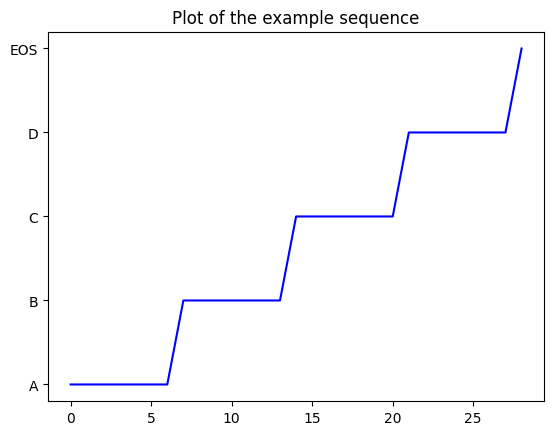



Num of sequences (Dataset size):	100 sequences
Num of tokens (Vocab size):		6 tokens

word_to_idx:
'A' -> 0
'B' -> 1
'C' -> 2
'D' -> 3
'EOS' -> 4
'UNK' -> 5

idx_to_word:
0 -> 'A'
1 -> 'B'
2 -> 'C'
3 -> 'D'
4 -> 'EOS'
5 -> 'UNK'

Dataset splitting:
Train:		80 samples
Validation:	10 samples
Test:		10 samples


In [8]:
# Initialize dataset
sequences = generate_dataset(num_sequences = 100)
word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
training_set, validation_set, test_set = create_datasets(sequences)

# Print
print(f"Example sequence: {sequences[0]}\n")

plt.plot(sequences[0], color='blue')
plt.title('Plot of the example sequence')
plt.show()

print(f"\n\nNum of sequences (Dataset size):\t{num_sequences} sequences")
print(f"Num of tokens (Vocab size):\t\t{vocab_size} tokens")
print("\nword_to_idx:")
for item in word_to_idx:
  print(f"'{item}' -> {word_to_idx[item]}")
print("\nidx_to_word:")
for item in idx_to_word:
  print(f"{item} -> '{idx_to_word[item]}'")
print(f"\nDataset splitting:")
print(f'Train:\t\t{len(training_set)} samples')
print(f'Validation:\t{len(validation_set)} samples')
print(f'Test:\t\t{len(test_set)} samples')

#### Training

In [9]:
# Breakdown 1
all_grads = [0] * len(training_set) # Save all 'grads' of each [inputs, targets in training_set] to calculate a mean grads later
all_train_losses = [0] * len(training_set)
all_valid_losses = [0] * len(validation_set)

# LOOP THROUGH SAMPLES IN VALIDATION SET
# 🟢 Can parallel
def loop_validation_set(params, hidden_size, vocab_size):
    for idx, (inputs, targets) in enumerate(validation_set):

        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        # Initialize [h]idden state and [c]ell state
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))
        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        # Backward pass
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

        # Save loss
        all_valid_losses[idx] = loss

# LOOP THROUGH SAMPLES IN TRAINING SET
# 🟢 Can parallel
def loop_training_set(params, hidden_size, vocab_size):
    for idx, (inputs, targets) in enumerate(training_set):
      
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        # Initialize [h]idden state and [c]ell state
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))
        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        # Backward pass
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

        # Save loss
        all_train_losses[idx] = loss
        # Save gradients
        all_grads[idx] = grads

# Train
def train_LSTM(num_epochs = 100, hidden_size = hidden_size, vocab_size = vocab_size):

    print('Training:')
    print('===========================================================')

    # Hidden Size: Number of dimensions of the hidden state
    # Vocab Size:  Number of unique tokens in dictionary of the dataset
    # Z Size:      Number of dimensions of the concatenated input = Hidden size + Vocab size
    z_size = hidden_size + vocab_size

    # Initialize LSTM network
    params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

    # Initialize hidden state
    hidden_state = np.zeros((hidden_size, 1))

    # Initialize train/val loss
    training_loss, validation_loss = [], []

    # LOOP THROUGH EPOCHS
    # 🔴 Cannot parallel
    for i in range(num_epochs + 1):
        
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0
        
        # LOOP THROUGH SAMPLES IN VALIDATION SET
        # 🟢 Can parallel
        loop_validation_set(params, hidden_size, vocab_size)
        
        # LOOP THROUGH SAMPLES IN TRAINING SET
        # 🟢 Can parallel
        loop_training_set(params, hidden_size, vocab_size)
        
        # Calculate mean of grads + Update params
        avg_grads = np.mean(all_grads, axis = 0)
        params = update_parameters(params, avg_grads, learning_rate = 10e-1)

        # Calculate sum of losses
        epoch_training_loss = np.sum(all_train_losses)
        epoch_validation_loss = np.sum(all_valid_losses)
                    
        # Save loss for later visualization
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        # Print train/val loss
        if i % 10 == 0:
            print(f'Epoch {i}:\tTrain loss = {round(training_loss[-1], 5)}\t Val loss = {round(validation_loss[-1], 5)}')
    
    print('===========================================================')

    # Return the trained LSTM model
    return params, training_loss, validation_loss

In [10]:
%%time
model, training_loss, validation_loss = train_LSTM(num_epochs = 80)

Training:
Epoch 0:	Train loss = 6.39633	 Val loss = 6.43842
Epoch 10:	Train loss = 4.92906	 Val loss = 4.95575
Epoch 20:	Train loss = 3.56282	 Val loss = 3.5813
Epoch 30:	Train loss = 2.65808	 Val loss = 2.6855
Epoch 40:	Train loss = 2.22029	 Val loss = 2.26368
Epoch 50:	Train loss = 2.00238	 Val loss = 2.06086
Epoch 60:	Train loss = 1.88109	 Val loss = 1.95306
Epoch 70:	Train loss = 1.79934	 Val loss = 1.87885
Epoch 80:	Train loss = 1.74354	 Val loss = 1.82295
CPU times: user 47.8 s, sys: 219 ms, total: 48 s
Wall time: 52 s


#### Result

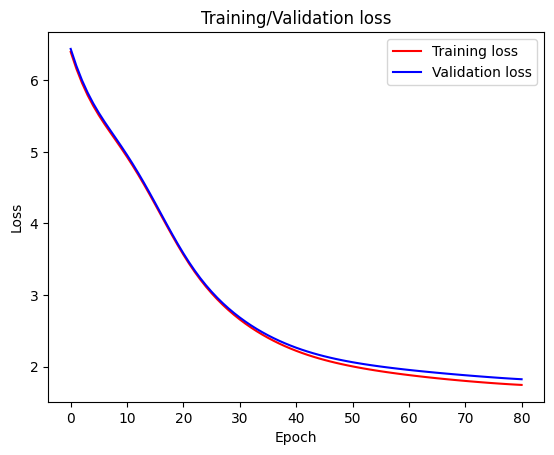

In [11]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.title('Training/Validation loss')
plt.show()

Input sequence:		['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B']
Output sequence:	['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'EOS', 'EOS', 'EOS', 'EOS']


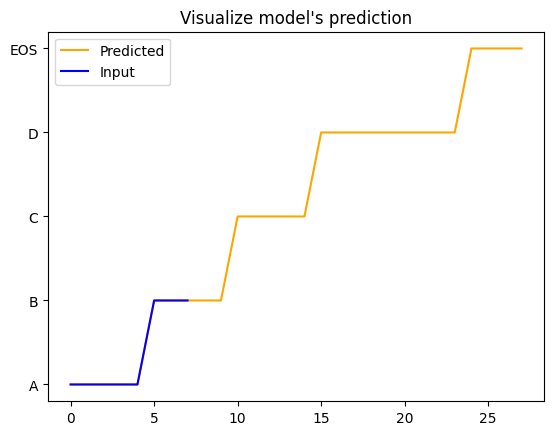

In [12]:
# Function: Predict following sequence from an input sequence
def inference(params, sentence='', num_generate=1):

    sentence = sentence.split(' ')
    
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    
    # Initialize hidden state as zeros
    h = np.zeros((hidden_size, 1))
    c = np.zeros((hidden_size, 1))

    # Generate hidden state for sentence
    _, _, _, _, C_s, _, h_s, _, outputs = forward(sentence_one_hot, h, c, params)
    
    # Output sentence
    output_sentence = sentence
    
    # Append first prediction
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    
    # Forward pass
    for i in range(num_generate - 1):

        # Get the latest prediction and latest hidden state
        output = outputs[-1]
        # hidden_state = hidden_states[-1]
        c = C_s[-1]
        h = h_s[-1]
    
        # Reshape our output to match the input shape of our forward pass
        output = output.reshape(1, output.shape[0], output.shape[1])
    
        # Forward pass
        _, _, _, _, C_s, _, h_s, _, outputs = forward(output, h, c, params)
        
        # Compute the index the most likely word and look up the corresponding word
        word = idx_to_word[np.argmax(outputs)]
        
        output_sentence.append(word)
        
    return output_sentence

# Input
input_sequence = 'A A A A A B B B'
input_sequence_len = len(input_sequence) - input_sequence.count(' ')

# Inference
result = inference(params=model, sentence=input_sequence, num_generate = 20)

# Print
print(f"Input sequence:\t\t{input_sequence.split(' ')}")
print(f"Output sequence:\t{result}")

# Plot
plt.plot(result, color='orange', label='Predicted')
plt.plot(result[:input_sequence_len], color='blue', label='Input')
plt.title('Visualize model\'s prediction')
plt.legend()
plt.show()